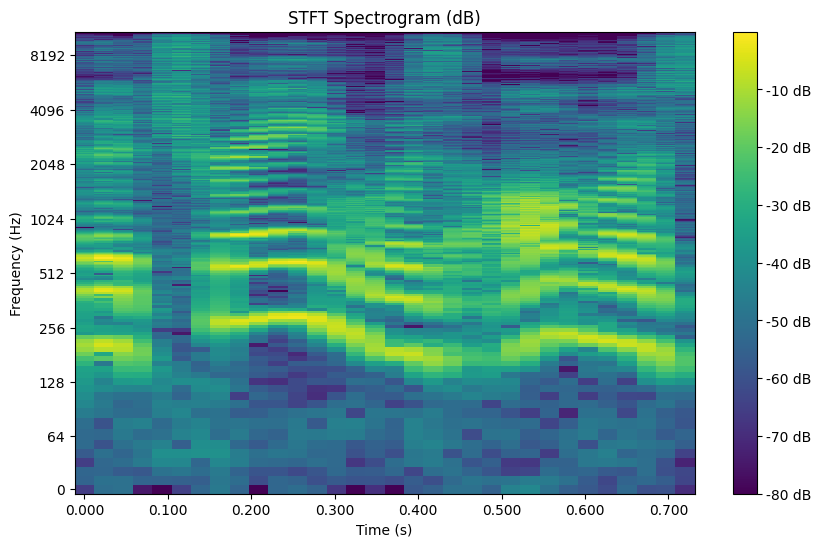

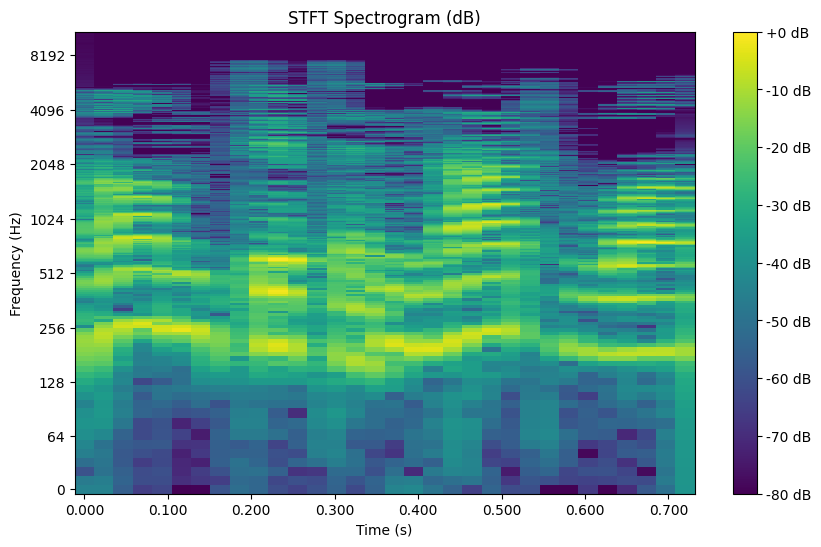

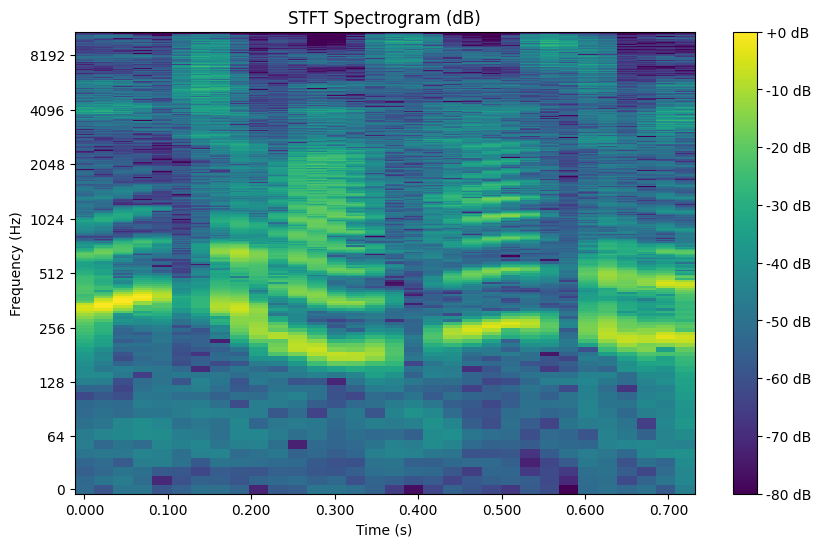

In [32]:

from matplotlib import pyplot as plt
import os
import librosa
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path


import numpy as np

import random

from scipy.signal import spectrogram

SAMPLE_RATE = 16000
DURATION = 1
BATCH_SIZE = 32

#path = 'audio_files/for-2sec/for-2seconds'
path = 'audio_files_samples'

class AudioData(Dataset):
    def __init__(self, root_dir, subset, transform, sample_rate=SAMPLE_RATE):
        self.root_dir = root_dir
        self.sample_rate = sample_rate
        self.transform = transform
        self.subset = subset
        self.sample_rate = SAMPLE_RATE
        self.classes = {'fake': 0, 'real': 1}
        self.files = []

        
        for label in self.classes:
            class_path = os.path.join(self.root_dir, subset, label)
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                self.files.append((file_path, self.classes[label]))

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        file_path, label = self.files[idx]
        spec = convert_to_spectrogram(file_path)
        # shit doesnt normalize yet
        # if self.transform:
        #     spec = self.transform(spec)
        return spec, label
        
        
        
# Useless
def process_audio_files(file):
    testing = []
    training = []
    validation = []
        
    for dirpath, dirnames, filenames in os.walk(file):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            if 'testing' in dirpath:
                testing.append(convert_to_spectrogram(filepath))
            elif 'training' in dirpath:
                training.append(convert_to_spectrogram(filepath))
            elif 'validation' in dirpath:
                validation.append(convert_to_spectrogram(filepath))

    return testing, training, validation

def convert_to_spectrogram(filepath):
    audio, _ = librosa.load(filepath, sr=SAMPLE_RATE, duration=DURATION)
    spec = librosa.stft(audio)
    return librosa.amplitude_to_db(np.abs(spec), ref=np.max)

def print_sample_spec(spec, is_numpy=False):
    # Need this or else cant plot with librosa
    if not is_numpy:
        spec = spec.numpy()
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(spec, x_axis='time', y_axis='log', cmap='viridis')
    #plt.imshow(spec, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('STFT Spectrogram (dB)')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

def get_sample(loader, get_label=False):
    spectrograms, labels = next(iter(loader))
    if get_label:
        return spectrograms[0], labels[0]
    return spectrograms[0]

def create_dataloaders(root_dir, batch_size=BATCH_SIZE):
    # How to normalize this shit?
    transform = transforms.Compose([
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    train_dataset = AudioData(root_dir=root_dir, subset='training', transform=transform)
    val_dataset = AudioData(root_dir=root_dir, subset='validation', transform=transform)
    test_dataset = AudioData(root_dir=root_dir, subset='testing', transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)#TODO: Change to true
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


train_loader, val_loader, test_loader = create_dataloaders(path, batch_size=BATCH_SIZE)
test, train, val = process_audio_files(path)

sample_spec = get_sample(train_loader)

print_sample_spec(test[0], True)
print_sample_spec(sample_spec)
print_sample_spec(test[4], True)


